In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from models import generator
from models import discriminator
from models import cycle_gan
from models import cycle_gan_architecture
from models import cycle_gan_optimizers
from models import cycle_gan_losses_functions

In [6]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

dataset = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\dawid\OneDrive\Pulpit\HandwrittenTextGenerator\data\sample_data",
    image_size=(160, 160), batch_size=1, seed=42).unbatch()

dataset_1 = dataset.filter(lambda x, y: y == 0)
dataset_2 = dataset.filter(lambda x, y: y == 1)

dataset_1_preprocessed = dataset_1.cache().map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(1)

dataset_2_preprocessed = dataset_2.cache().map(
    preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(1)

In [13]:
gen_1 = generator.Generator()
gen_2 = generator.Generator()

disc_1 = discriminator.Discriminator()
disc_2 = discriminator.Discriminator()

cyc_models = cycle_gan_architecture.CycleGANArchitecture(
    gen_1, gen_2, disc_1, disc_2
)

opt = cycle_gan_optimizers.CycleGANOptimizers(
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
)

ls_fc = cycle_gan_losses_functions.CycleGANLossesFunctions(
    cycle_gan_losses_functions.generator_loss(tf.keras.losses.BinaryCrossentropy(from_logits=True)),
    cycle_gan_losses_functions.discriminator_loss(tf.keras.losses.BinaryCrossentropy(from_logits=True), 0.5),
    cycle_gan_losses_functions.cycle_loss(tf.keras.losses.MeanSquaredError(), 10),
    cycle_gan_losses_functions.identity_loss(tf.keras.losses.MeanSquaredError(), 5),
)

cyc_gan = cycle_gan.CycleGAN(architecture=cyc_models)
cyc_gan.compile(opt, ls_fc)

In [9]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [10]:
sample_horse = next(iter(dataset_1_preprocessed))
sample_zebra = next(iter(dataset_2_preprocessed))

0


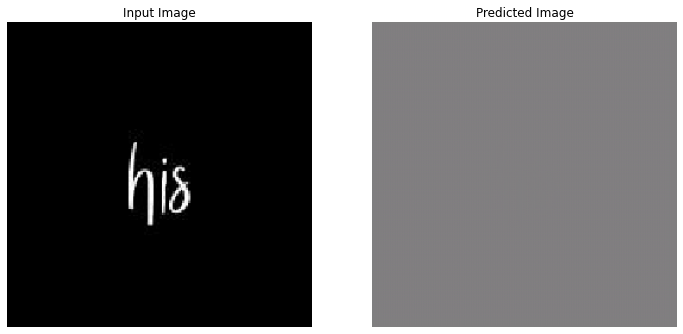

      2/Unknown - 143s 65s/step - total_generator_1_loss: 25.0160 - total_generator_2_loss: 23.1308 - discriminator_1_loss: 0.8403 - discriminator_2_loss: 0.8128

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(epoch)
    generate_images(cyc_gan.architecture.generator_1, sample_horse)
    cyc_gan.fit(tf.data.Dataset.zip((dataset_1_preprocessed, dataset_2_preprocessed)), batch_size=1)